In [25]:
import pandas as pd
import os
import sys
from torch.utils.data import Dataset, DataLoader
from dataset import DCMImageDataset

pd.set_option('mode.chained_assignment',  None)
data_dir = "../../dataset/rsna-2024-lumbar-spine-degenerative-classification/"

coordinates = pd.read_csv(data_dir + 'train_label_coordinates.csv')
descriptions = pd.read_csv(data_dir + 'train_series_descriptions.csv')
train = pd.read_csv(data_dir + 'train.csv')


d = DCMImageDataset(
	series='Axial T2',
	coordinates_file=coordinates,
	descriptions_file=descriptions,
	train_file=train,
	img_dir=data_dir
	)

c:\Users\neo64\AI\deeplearn\rsna2024\dataset.py:54: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df[self.label_column] = self.df[self.label_column].replace(mapping)


In [26]:
import torch
import torch.nn as nn
from torchsummary import summary
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.nn import functional as F
import numpy as np
import torchvision
import pandas as pd
import os
import pydicom

In [27]:
class Model(nn.Module):
    def ConvLayer(self, in_channel, out_channel):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=3, padding=1, dtype=torch.double),
            nn.ReLU(),
            nn.AvgPool2d(2)
        )
    
    def FcLayer(self, in_dim, out_dim, bias=True):
        return nn.Sequential(
            nn.Linear(in_features=in_dim, out_features=out_dim, bias=bias, dtype=torch.double),
            nn.ReLU(),
        )

    def __init__(self, output):
        super(Model, self).__init__()
        self.layer1 = self.ConvLayer(1, 32)
        self.layer2 = self.ConvLayer(32, 64)
        self.layer3 = self.ConvLayer(64, 128)
        self.layer4 = self.ConvLayer(128, 256)
        self.layer5 = self.ConvLayer(256, 256)
        
        self.fc1 = self.FcLayer(7* 7* 256, 2048)
        self.fc2 = self.FcLayer(2048, 64)
        self.fc3 = nn.Linear(64, 3* output, bias=False, dtype=torch.double)
        

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.reshape(-1, 7* 7* 256)
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [28]:
model = Model(10)
model = model.to('cuda')

In [29]:
lr = 10**-3
optim = torch.optim.Adam(params=model.parameters(), lr=lr)
epoch = 30
loss_fn = nn.CrossEntropyLoss()

In [30]:
len(d)

79979

In [31]:
batch = 128
train_set, val_set = torch.utils.data.random_split(d, [60000, 19979])
train_loader = DataLoader(train_set, batch_size=batch, shuffle=True, num_workers=6, drop_last=True)
test_loader = DataLoader(val_set, batch_size=batch, shuffle=True, num_workers=6, drop_last=True)

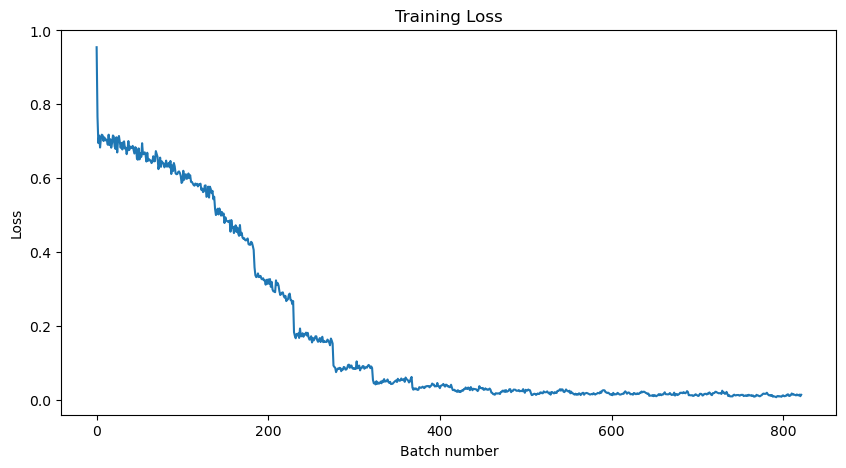

acc : 92.83854166666666
loss : 0.016554529619398527
loss : 0.00778311125990775
loss : 0.02259897547728558
loss : 0.012769983776142602
loss : 0.01249691405083101
loss : 0.015066683742815796


KeyboardInterrupt: 

In [32]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

load_path = "weights/Axial_t2_3.pt"
save_path = "weights/Axial_t2_3.pt"
#model.load_state_dict(torch.load(load_path))
print_acc = 0
losses = []
for epoch_cnt in range(epoch):
    loss_sum = 0

    for i, (input, answer) in enumerate(train_loader):
        optim.zero_grad()

        input = input.to('cuda').unsqueeze(1)
        answer = answer[:, 15:25].type(torch.LongTensor).to('cuda')
        output = model(input).to('cuda')
        output = output.reshape(-1, 3)
        answer = answer.reshape(-1)

        loss = loss_fn(output, answer)
        loss.backward()

        optim.step()
        
        loss_sum += loss.item()
        print(f"loss : {loss.item()}")
        if i%10==9:
            losses.append(loss_sum / 10)
            loss_sum = 0
            torch.save(model.state_dict(), save_path)
            
            clear_output(wait=True)
            plt.figure(figsize=(10, 5))
            plt.plot(losses)
            plt.xlabel('Batch number')
            plt.ylabel('Loss')
            plt.title('Training Loss')
            plt.show()
            print(f"acc : {print_acc}")


    with torch.no_grad():
        total_acc = 0
        for i, (input, answer) in enumerate(test_loader):
            input = input.to('cuda').unsqueeze(1)
            answer = answer[:, 15:25].type(torch.LongTensor).to('cuda')
            output = model(input).to('cuda')
            output = output.reshape(-1, 3)
            answer = answer.reshape(-1)
            output = torch.argmax(output, dim=1)

            acc = torch.sum(output == answer).item() / len(output)
            total_acc += acc
        print_acc = total_acc / len(test_loader) * 100
        print(f"acc : {round(total_acc / len(test_loader) * 100, 4)}%")


In [17]:
d.label_column

Index(['spinal_canal_stenosis_l1_l2', 'spinal_canal_stenosis_l2_l3',
       'spinal_canal_stenosis_l3_l4', 'spinal_canal_stenosis_l4_l5',
       'spinal_canal_stenosis_l5_s1', 'left_neural_foraminal_narrowing_l1_l2',
       'left_neural_foraminal_narrowing_l2_l3',
       'left_neural_foraminal_narrowing_l3_l4',
       'left_neural_foraminal_narrowing_l4_l5',
       'left_neural_foraminal_narrowing_l5_s1',
       'right_neural_foraminal_narrowing_l1_l2',
       'right_neural_foraminal_narrowing_l2_l3',
       'right_neural_foraminal_narrowing_l3_l4',
       'right_neural_foraminal_narrowing_l4_l5',
       'right_neural_foraminal_narrowing_l5_s1',
       'left_subarticular_stenosis_l1_l2', 'left_subarticular_stenosis_l2_l3',
       'left_subarticular_stenosis_l3_l4', 'left_subarticular_stenosis_l4_l5',
       'left_subarticular_stenosis_l5_s1', 'right_subarticular_stenosis_l1_l2',
       'right_subarticular_stenosis_l2_l3',
       'right_subarticular_stenosis_l3_l4',
       'right_subart

In [8]:
import pydicom

study_id = "44036939"

model_Sagittal_T2 = Model(5).to('cuda')
model_Sagittal_T1 = Model(10).to('cuda')
model_Axial_T2 = Model(10).to('cuda')

model_Sagittal_T2.load_state_dict(torch.load("weights/Sagittal_t2_1.pt"))
model_Sagittal_T1.load_state_dict(torch.load("weights/Sagittal_t1_2.pt"))
model_Axial_T2.load_state_dict(torch.load("weights/Axial_t2_3.pt"))

test_descriptions = pd.read_csv(data_dir + 'test_series_descriptions.csv')

series_id_list = {
    "Sagittal_T2_id" : "3844393089",
    "Sagittal_T1_id" : "2828203845",
    "Axial_T2_id" : "3481971518"
}


class TestDataset(Dataset):
    def __init__(self, person_id, data_dir):
        self.person_id = person_id
        self.series = {}
        test_descriptions = pd.read_csv(data_dir + 'test_series_descriptions.csv')
        for i in range(len(test_descriptions)):
            if str(test_descriptions.iloc[i]['study_id']) != self.person_id:
                continue

            self.series[test_descriptions.iloc[i]['series_description']] = test_descriptions.iloc[i]['series_id']

        self.dataset = {}
        for key in self.series.keys():
            img_path = data_dir + 'test_images/' + self.person_id + '/' + str(self.series[key])
            files = os.listdir(str(img_path))

            for file in files:
                image = torch.from_numpy(pydicom.dcmread(img_path + '/' + file).pixel_array.astype(np.float64))
                image = image.unsqueeze(0)
                image = image.unsqueeze(0)
                image = F.interpolate(image, (224,224), mode='bilinear')
                image = image.reshape(224, 224)
                image = F.normalize(image)

                if key in self.dataset.keys():
                    self.dataset[key].append(image)
                else:
                    self.dataset[key]=[]
                    self.dataset[key].append(image)


    def __getitem__(self, series):
        return self.dataset[series]


In [32]:
dataset = TestDataset(
    person_id='44036939',
    data_dir=data_dir
    )

d3 = np.array(dataset['Axial T2'])
d2 = np.array(dataset['Sagittal T1'])
d1 = np.array(dataset['Sagittal T2/STIR'])

d1 = torch.from_numpy(d1).to('cuda')
d1 = d1.reshape(-1, 1, 224, 224)
d2 = torch.from_numpy(d2).to('cuda')
d2 = d2.reshape(-1, 1, 224, 224)
d3 = torch.from_numpy(d3).to('cuda')
d3 = d3.reshape(-1, 1, 224, 224)

output1 = model_Sagittal_T2(d1)
output1 = output1.reshape(-1, 3)
softmax = nn.Softmax(dim=1)
result1 = softmax(output1)
result1 = result1.reshape(-1, 5, 3)
result1 = torch.mean(result1, dim=0)
df1 = pd.DataFrame(result1.to('cpu').tolist())

output2 = model_Sagittal_T1(d2)
output2 = output2.reshape(-1, 3)
softmax = nn.Softmax(dim=1)
result2 = softmax(output2)
result2 = result2.reshape(-1, 10, 3)
result2 = torch.mean(result2, dim=0)
df2 = pd.DataFrame(result2.to('cpu').tolist())

output3 = model_Axial_T2(d3)
output3 = output3.reshape(-1, 3)
softmax = nn.Softmax(dim=1)
result3 = softmax(output3)
result3 = result3.reshape(-1, 10, 3)
result3 = torch.mean(result3, dim=0)
df3 = pd.DataFrame(result3.to('cpu').tolist())

df3
# Axial T2, L/R Subarticular Stenosis
# Sagittal T2, Spinal Canal Stenosis
# Sagittal T1, L/R Neural Foraminal Narrowing

,0,1,2
0,0.998547,0.001290,0.000162
1,0.594256,0.405645,0.000099
2,0.416568,0.295388,0.288044
3,0.047119,0.094359,0.858522
4,0.957963,0.025145,0.016892
5,0.963318,0.036644,0.000039
6,0.437408,0.562100,0.000492
7,0.094640,0.418862,0.486499
8,0.200548,0.395532,0.403920
9,0.877810,0.101963,0.020226
